<a href="https://colab.research.google.com/github/tanujsaini05/DeepLearning-using-TensorFlow/blob/main/%F0%9F%8D%94%F0%9F%91%81%EF%B8%8F(Food_Vision_Big).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Let's start With our Food Vision Model

In [1]:
## lets check the gpu

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8b4dfbd8-731d-e8ef-d19b-3d0629b21d12)


In [2]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [3]:
from helper_functions import make_confusion_matrix,plot_loss_curves,walk_through_dir,unzip_data,create_tensorboard_callback,compare_historys

In [4]:
import tensorflow_datasets as tfds

In [5]:
datasets_list = tfds.list_builders()

In [6]:
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


### let's import dataset from tensorflow_datasets

In [7]:
(train_data,test_data),ds_info=tfds.load('Food101',
                                         split=["train", "validation"],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteW2E6A0/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteW2E6A0/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
train_one_sample=train_data.take(1)

In [10]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
for image,label in train_one_sample:
  print(f'image shape {image.shape}')
  print(f'image data type {image.dtype}')
  print(f'Target classs from 101 {label}')
  print(f'Class name (str form): {class_names[label.numpy()]}')

image shape (382, 512, 3)
image data type <dtype: 'uint8'>
Target classs from 101 52
Class name (str form): gyoza


In [12]:
image

<tf.Tensor: shape=(382, 512, 3), dtype=uint8, numpy=
array([[[207, 220, 237],
        [207, 220, 237],
        [207, 220, 236],
        ...,
        [ 10,  11,  13],
        [ 11,  12,  14],
        [ 12,  13,  15]],

       [[208, 219, 237],
        [207, 220, 236],
        [208, 220, 236],
        ...,
        [  9,  10,  12],
        [ 10,  11,  13],
        [ 11,  12,  14]],

       [[216, 225, 242],
        [213, 225, 239],
        [214, 223, 238],
        ...,
        [ 11,  12,  14],
        [ 12,  13,  15],
        [ 12,  13,  15]],

       ...,

       [[ 33,  10,  16],
        [ 34,  11,  17],
        [ 33,  12,  17],
        ...,
        [ 10,   6,   5],
        [ 13,   7,   7],
        [ 15,   9,   9]],

       [[ 37,  12,  18],
        [ 36,  13,  19],
        [ 35,  15,  17],
        ...,
        [ 14,  10,   9],
        [ 19,  13,  13],
        [ 21,  15,  15]],

       [[ 39,  14,  20],
        [ 37,  14,  20],
        [ 36,  14,  17],
        ...,
        [ 19,  15,  1

In [13]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [14]:
import matplotlib.pyplot as plt

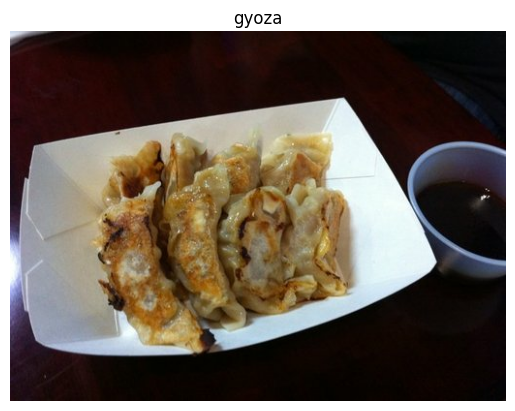

In [15]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

### function to preprocess an image

In [16]:
def preprocess_img(image,label,img_shape=224):

  image=tf.image.resize(image, [224,224])
  return tf.cast(image,tf.float32),label

In [17]:
preprocessed_img = preprocess_img(image, label)[0]

In [18]:
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[207.12596  , 219.87404  , 236.77328  ],
        [206.75159  , 219.39891  , 235.39891  ],
        [206.33514  , 216.86098  , 232.36958  ],
        ...,
        [ 10.433058 ,  11.433058 ,  13.433058 ],
        [  9.974804 ,  10.974804 ,  12.974804 ],
        [ 11.004499 ,  12.004499 ,  14.004499 ]],

       [[214.51498  , 225.25287  , 240.26627  ],
        [214.24043  , 223.17825  , 238.07462  ],
        [213.40561  , 221.28954  , 234.25638  ],
        ...,
        [ 12.571472 ,  13.571472 ,  15.571472 ],
        [ 11.928558 ,  12.928558 ,  14.928558 ],
        [ 11.941964 ,  12.941964 ,  14.941964 ]],

       [[222.75032  , 229.13902  , 242.17444  ],
        [214.43494  , 220.89125  , 233.28763  ],
        [200.73564  , 205.20886  , 216.71046  ],
        ...,
        [  9.681468 ,  10.681468 ,  12.681468 ],
        [  8.874987 ,   9.874987 ,  11.874987 ],
        [  7.9464283,   8.946428 ,  10.946428 ]],

       ...,

     

In [19]:
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[207 220 237]
  [207 220 237]
  [207 220 236]
  ...
  [ 10  11  13]
  [ 11  12  14]
  [ 12  13  15]]

 [[208 219 237]
  [207 220 236]
  [208 220 236]
  ...
  [  9  10  12]
  [ 10  11  13]
  [ 11  12  14]]]...,
Shape: (382, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[207.12596  219.87404  236.77328 ]
  [206.75159  219.39891  235.39891 ]
  [206.33514  216.86098  232.36958 ]
  ...
  [ 10.433058  11.433058  13.433058]
  [  9.974804  10.974804  12.974804]
  [ 11.004499  12.004499  14.004499]]

 [[214.51498  225.25287  240.26627 ]
  [214.24043  223.17825  238.07462 ]
  [213.40561  221.28954  234.25638 ]
  ...
  [ 12.571472  13.571472  15.571472]
  [ 11.928558  12.928558  14.928558]
  [ 11.941964  12.941964  14.941964]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


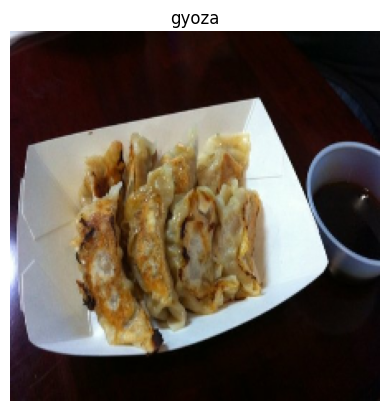

In [20]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [21]:
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


test_data=test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [23]:
from helper_functions import create_tensorboard_callback

model_checkpoint=tf.keras.callbacks.ModelCheckpoint('model_checkpoints/cp.ckpt',monitor='val_accuracy',
                                     save_best_only=True,
                                     save_weights_only=True,
                                     verbose=0)

### setting policy to mixed_precision

In [24]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

### feature extraction model using efficentNetB0 to extract features and architecture of the model.

In [25]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False


16705208/16705208 [==============================] - 2s 0us/step


In [26]:
inputs=tf.keras.Input(shape=(224,224,3))
x=base_model(inputs)
x=tf.keras.layers.GlobalAvgPool2D(name="pooling_layer")(x)
output=tf.keras.layers.Dense(len(class_names),activation='softmax')(x)
model=tf.keras.Model(inputs,output)

In [27]:
for layer in model.layers:
  print(layer.dtype,layer.dtype_policy)

float32 <Policy "float32">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">


In [28]:
model.compile(metrics=['accuracy'],loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam())

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (505.39 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [30]:
for layer in base_model.layers:
  print(f'here is dtype{layer.dtype}     and policy   {layer.dtype_policy}')

here is dtypefloat32     and policy   <Policy "float32">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16">
here is dtypefloat32     and policy   <Policy "mixed_float16"

In [31]:
hist_1=model.fit(train_data,validation_data=test_data,
          callbacks=[create_tensorboard_callback('training_logs',experiment_name='efficientnetB0_food101_feature_extration_model'),model_checkpoint],
          epochs=5,steps_per_epoch=len(train_data),
          validation_steps=int(0.15*len(test_data)))

Saving TensorBoard log files to: training_logs/efficientnetB0_food101_feature_extration_model/20231009-151104
Epoch 1/5
2368/2368 [==============================] - 186s 71ms/step - loss: 1.7735 - accuracy: 0.5672 - val_loss: 1.1223 - val_accuracy: 0.6981
Epoch 2/5
2368/2368 [==============================] - 169s 71ms/step - loss: 1.2672 - accuracy: 0.6729 - val_loss: 1.0218 - val_accuracy: 0.7238
Epoch 3/5
2368/2368 [==============================] - 169s 71ms/step - loss: 1.1281 - accuracy: 0.7048 - val_loss: 0.9949 - val_accuracy: 0.7272
Epoch 4/5
2368/2368 [==============================] - 163s 69ms/step - loss: 1.0458 - accuracy: 0.7245 - val_loss: 0.9899 - val_accuracy: 0.7312
Epoch 5/5
2368/2368 [==============================] - 177s 75ms/step - loss: 0.9772 - accuracy: 0.7403 - val_loss: 0.9624 - val_accuracy: 0.7312


In [32]:
model.evaluate(test_data)

790/790 [==============================] - 52s 66ms/step - loss: 0.9723 - accuracy: 0.7333


[0.9723281860351562, 0.7332673072814941]

### plotting loss_curves

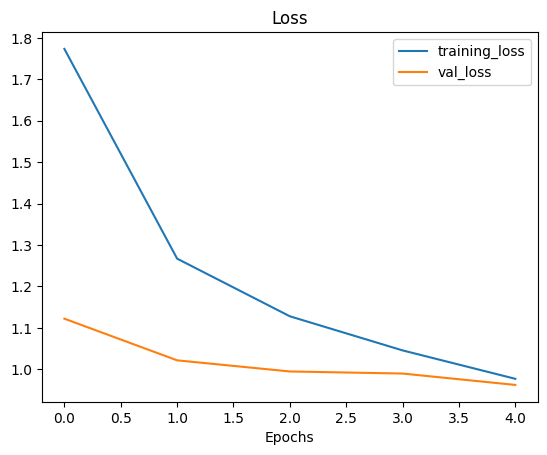

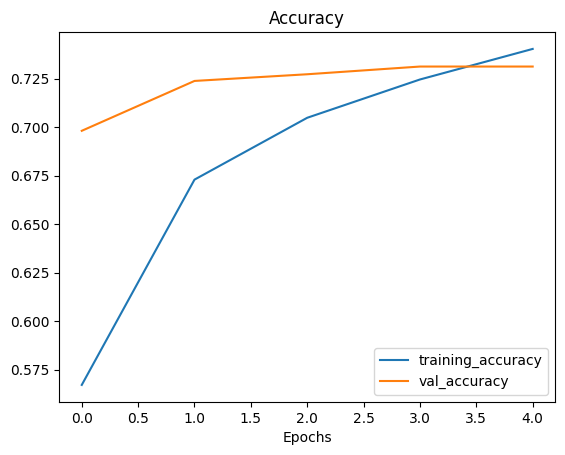

In [33]:
plot_loss_curves(hist_1)

In [42]:
# import os

# dir=os.makedirs('dirve/Mydrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/')
# model.save()

### Saving and loading our Model back

In [35]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [36]:
loaded_model=tf.keras.saving.load_model('07_efficientnetb0_feature_extract_model_mixed_precision/')

In [37]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 55s 66ms/step - loss: 0.9723 - accuracy: 0.7333


[0.9723362326622009, 0.7332673072814941]

In [38]:
base_model_2=tf.keras.applications.EfficientNetB0(include_top=False)
base_model_2.trainable=True

In [39]:
model_2=tf.keras.Sequential([tf.keras.layers.Input(shape=(224,224,3)),
                             base_model_2,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(101,activation='softmax')])

In [40]:
model_2.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam())

In [41]:
hist_2=model_2.fit(train_data,validation_data=test_data,
          callbacks=[create_tensorboard_callback('training_logs/trainable_true',experiment_name='efficientnetB0_food101_feature_extration_model'),model_checkpoint],
          epochs=3,steps_per_epoch=len(train_data),
          validation_steps=int(0.15*len(test_data)))

Saving TensorBoard log files to: training_logs/trainable_true/efficientnetB0_food101_feature_extration_model/20231009-153001
Epoch 1/3
2368/2368 [==============================] - 456s 167ms/step - loss: 1.6593 - accuracy: 0.5771 - val_loss: 1.0370 - val_accuracy: 0.7164
Epoch 2/3
2368/2368 [==============================] - 391s 165ms/step - loss: 1.0682 - accuracy: 0.7155 - val_loss: 1.0388 - val_accuracy: 0.7243
Epoch 3/3
2368/2368 [==============================] - 415s 175ms/step - loss: 0.8460 - accuracy: 0.7671 - val_loss: 0.9410 - val_accuracy: 0.7526


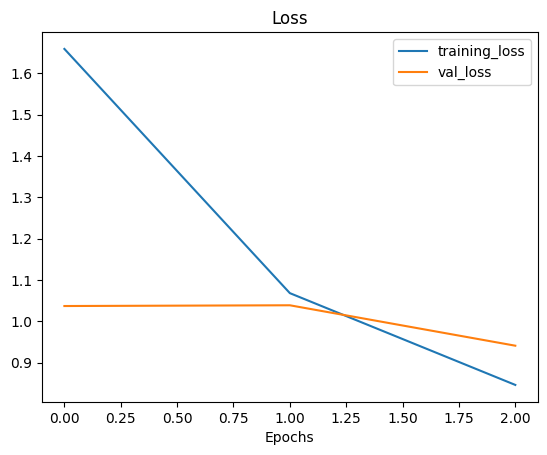

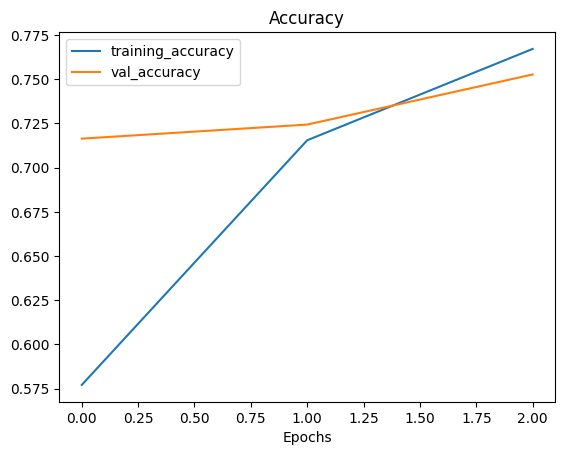

In [43]:
plot_loss_curves(hist_2)

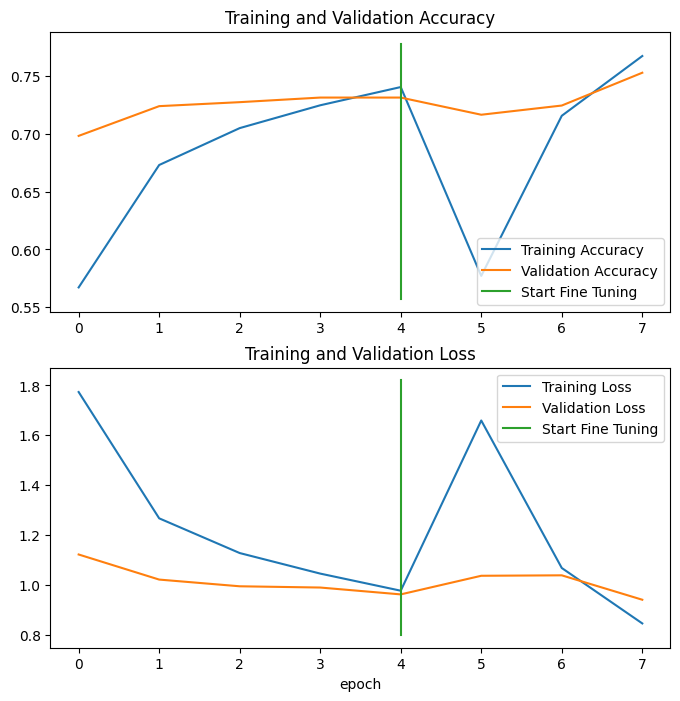

In [44]:
compare_historys(hist_1,hist_2)

### let's go with fie tunning

In [45]:
base_model.trainable=False

In [46]:
for layer in model.layers:
  layer.trainable=True #set all layers to trainable true
  print(layer.trainable)

True
True
True
True


In [47]:
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
rescaling_1 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float

### let's create some new callbacks

In [48]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_checkpoints/final_one/cp_3.ckpt',
                                                      save_best_only=True,
                                                      monitor="val_loss")
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=0.2,verbose=1,min_lr=1e-7)

In [49]:
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [50]:
model.fit(train_data,epochs=100,steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=int(0.15*len(test_data)),
          callbacks=[model_checkpoint,reduce_lr,early_stopping,])

Epoch 1/100
2368/2368 [==============================] - 512s 192ms/step - loss: 1.1493 - accuracy: 0.6959 - val_loss: 0.7425 - val_accuracy: 0.7887 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 457s 192ms/step - loss: 0.6699 - accuracy: 0.8174 - val_loss: 0.6847 - val_accuracy: 0.8112 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 460s 194ms/step - loss: 0.4518 - accuracy: 0.8795 - val_loss: 0.6651 - val_accuracy: 0.8173 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 459s 194ms/step - loss: 0.3012 - accuracy: 0.9215 - val_loss: 0.6578 - val_accuracy: 0.8231 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9478
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 408s 172ms/step - loss: 0.2084 - accuracy: 0.9478 - val_loss: 0.7238 - val_accuracy: 0.8106 - lr: 1.0000e-04
Epoch 

In [51]:
model.save('content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_mixed_precision')

In [ ]:
load_model_1=tf.keras.models.load_model('content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_mixed_precision')

### Let's do some Preditions

In [53]:
pred_probs=model.predict(test_data,verbose=1)

790/790 [==============================] - 58s 71ms/step


In [54]:
len(pred_probs)

25250

In [55]:
pred_probs.shape



(25250, 101)

In [57]:
pred_probs[:10]


array([[6.177e-01, 1.895e-05, 1.657e-04, ..., 4.512e-05, 1.192e-07,
        1.810e-01],
       [4.172e-07, 1.192e-07, 1.192e-07, ..., 5.960e-08, 5.960e-08,
        0.000e+00],
       [2.546e-04, 0.000e+00, 5.672e-03, ..., 4.709e-05, 1.419e-05,
        1.428e-04],
       ...,
       [1.640e-03, 2.724e-05, 2.205e-05, ..., 5.376e-05, 5.083e-04,
        1.049e-02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.192e-07, 8.070e-05,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]], dtype=float16)

In [58]:
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]


array([ 0, 44, 16, 79, 16, 51, 12, 52,  3, 13])

In [59]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [60]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)


25250

### Evaluating the Model Prediction

In [61]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy


0.009346534653465346

In [62]:
from helper_functions import make_confusion_matrix

In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02     25250
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 1.0,
  'recall': 0.009346534653465346,
  'f1-score': 0.018519971749195636,
  'support': 25250},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '10': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '11': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '12': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '13': {'precisio

In [66]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.018519971749195636,
 'baby_back_ribs': 0.0,
 'baklava': 0.0,
 'beef_carpaccio': 0.0,
 'beef_tartare': 0.0,
 'beet_salad': 0.0,
 'beignets': 0.0,
 'bibimbap': 0.0,
 'bread_pudding': 0.0,
 'breakfast_burrito': 0.0,
 'bruschetta': 0.0,
 'caesar_salad': 0.0,
 'cannoli': 0.0,
 'caprese_salad': 0.0,
 'carrot_cake': 0.0,
 'ceviche': 0.0,
 'cheesecake': 0.0,
 'cheese_plate': 0.0,
 'chicken_curry': 0.0,
 'chicken_quesadilla': 0.0,
 'chicken_wings': 0.0,
 'chocolate_cake': 0.0,
 'chocolate_mousse': 0.0,
 'churros': 0.0,
 'clam_chowder': 0.0,
 'club_sandwich': 0.0,
 'crab_cakes': 0.0,
 'creme_brulee': 0.0,
 'croque_madame': 0.0,
 'cup_cakes': 0.0,
 'deviled_eggs': 0.0,
 'donuts': 0.0,
 'dumplings': 0.0,
 'edamame': 0.0,
 'eggs_benedict': 0.0,
 'escargots': 0.0,
 'falafel': 0.0,
 'filet_mignon': 0.0,
 'fish_and_chips': 0.0,
 'foie_gras': 0.0,
 'french_fries': 0.0,
 'french_onion_soup': 0.0,
 'french_toast': 0.0,
 'fried_calamari': 0.0,
 'fried_rice': 0.0,
 'frozen_yogurt': 0.0,
 'g

In [67]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()


class_name  f1-score
0     apple_pie   0.01852
64    miso_soup   0.00000
74  peking_duck   0.00000
73  panna_cotta   0.00000
72     pancakes   0.00000

In [76]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  # class_name = random.choice(class_names)
  # filename = random.choice(os.listdir( + "/" + class_name))
  # filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);